# Clustering Retail Sales Analysis using KMeans in PySpark

Kita akan menggunakan standar CRISP-DM agar menghasilkan Data Driven Decission Making yang berkualitas

## Data Understanding

In [4]:
# import os
# os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

#processing
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

#modeling
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#membuat entry point 
spark = SparkSession.builder.appName("Retail Sales").getOrCreate()

In [6]:
# dir(spark)

In [7]:
#read csv
df = spark.read.csv('online_retail.csv',header=True,escape="\"")

In [8]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [9]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



### Exploratory Data analysis aka EDA
melakukan proses untuk menganalisis dan memahami data secara visual dan statistik guna mengidentifikasi pola, hubungan, dan karakteristik penting dalam data.

In [10]:
# dir(df)
df.describe(['Quantity','UnitPrice']).show()

+-------+------------------+-----------------+
|summary|          Quantity|        UnitPrice|
+-------+------------------+-----------------+
|  count|            541909|           541909|
|   mean|  9.55224954743324| 4.61111362608923|
| stddev|218.08115785023386|96.75985306117973|
|    min|                -1|        -11062.06|
|    max|               992|            99.96|
+-------+------------------+-----------------+



##### Berapa Jumlah Customer Berdasarkan CustomerID?

In [11]:
df.select('CustomerID').distinct().count()

4373


##### Berapa jumlah negara yang pernah melakukan transaksi?

In [42]:
df.select('Country').distinct().count()

38

##### Berapa Jumlah negara yang paling sering melakukan Transaki?

In [14]:
df.groupBy('Country') \
    .agg(countDistinct('CustomerID') \
    .alias('Jumlah')) \
    .orderBy(desc('Jumlah')) \
    .show()

# result = df.groupBy('Country') \
#     .agg(countDistinct('CustomerID') \
#     .alias('Jumlah'))
# result.show()

+---------------+------+
|        Country|Jumlah|
+---------------+------+
| United Kingdom|  3950|
|        Germany|    95|
|         France|    87|
|          Spain|    31|
|        Belgium|    25|
|    Switzerland|    21|
|       Portugal|    19|
|          Italy|    15|
|        Finland|    12|
|        Austria|    11|
|         Norway|    10|
|        Denmark|     9|
|Channel Islands|     9|
|      Australia|     9|
|    Netherlands|     9|
|         Sweden|     8|
|         Cyprus|     8|
|          Japan|     8|
|         Poland|     6|
|         Greece|     4|
+---------------+------+
only showing top 20 rows



### Data Processing

In [15]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate",'yy/MM/dd HH:mm'))
df.select(max('date')).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-12-10 16:21:00|
+-------------------+



In [16]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

#### Berapa skor Rerency untuk setiap Pelanggan?

In [17]:
df = df.withColumn("from_date",lit("12/1/10 08:26"))
df = df.withColumn("from_date",to_timestamp("from_date","yy/MM/dd HH:mm"))

# df.show()
df_2 = df.withColumn('from_date',to_timestamp(col('from_date'))) \
    .withColumn('recency',col("date") \
    .cast('long') - col('from_date') \
    .cast('long'))

In [18]:
df_2.show(1,0)

+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+-------+
|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |recency|
+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+-------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 8:26|2.55     |17850     |United Kingdom|2012-01-10 08:26:00|2012-01-10 08:26:00|0      |
+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+-------+
only showing top 1 row



In [19]:
df_2 = df_2.join(df_2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df_2.show()

+-------+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+-------+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|    540|   536369|    21756|BATH BUILDING BLO...|       3|12/1/10 8:35|     5.95|     13047|United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|
|   2040|   536371|    22086|PAPER CHAIN KIT 5...|      80|12/1/10 9:00|     2.55|     13748|United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|
|   3960|   536375|   85123A|WHITE HANGING HEA...|       6|12/1/10 9:32|     2.55|     17850|United Kingdom|2012-01-10 09:32:00|2012-01-10 08:26:00|
|   3960|   536375|    71053| WHITE METAL LANTERN|       6|12/1/10 9:32|     3.39|     17850|United Kingdo

#### Berapa banyak freq pembelian customer berdasar CustomerID?

In [20]:
df_freq = df_2.groupBy('CustomerID') \
    .agg(count('InvoiceDate') \
    .alias('Freq Jumlah')) 
df_freq.show()

+----------+-----------+
|CustomerID|Freq Jumlah|
+----------+-----------+
|     16250|         14|
|     15574|        121|
|     15271|         24|
|     15555|         37|
|     17757|         49|
|     13187|         37|
|     13107|         21|
|     16303|         35|
|     13174|        169|
|     17128|         14|
|     14810|         23|
|     16654|          9|
|     17917|         29|
|     17855|         17|
|     15107|          5|
|     14443|         20|
|     12386|          8|
|     14236|          3|
|     13030|         60|
|     14618|          1|
+----------+-----------+
only showing top 20 rows



In [21]:
df_3 =df_2.join(df_freq,on='CustomerID',how='inner')
df_3.show(5,0)

+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+-----------+
|CustomerID|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |Freq Jumlah|
+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+-----------+
|13047     |540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5.95     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|1          |
|13748     |2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2.55     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|1          |
|17850     |3960   |536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 9:32|2.55     |United Kingdom|201

#### Menghitung Total Pengeluaran dari setiap pembelian

In [22]:
#Membuat Kolom Total Amount dengan mengkalikan Nilai Quantity dengan UnitPrice
val_M = df_3.withColumn('Total Amount',col("Quantity")*col('UnitPrice'))

In [23]:
# Pengelompokan berdasarkan CustomerID dengan aggregasi fungsi sum
val_m = val_M.groupBy('CustomerID') \
    .agg(sum('Total Amount') \
    .alias('monetary_value'))

In [24]:
val_m.show(5,0)

+----------+-----------------+
|CustomerID|monetary_value   |
+----------+-----------------+
|16250     |226.14           |
|15574     |375.65           |
|15271     |111.75           |
|15555     |620.3499999999998|
|17757     |385.25           |
+----------+-----------------+
only showing top 5 rows



In [25]:
df_3.show(5,0)

+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+-----------+
|CustomerID|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |Freq Jumlah|
+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+-----------+
|13047     |540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5.95     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|1          |
|13748     |2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2.55     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|1          |
|17850     |3960   |536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 9:32|2.55     |United Kingdom|201

In [26]:
df_new = val_m.join(df_3,on='CustomerID',how='inner')
df_new.show(1,0)

+----------+--------------+-------+---------+---------+------------------------+--------+------------+---------+--------------+-------------------+-------------------+-----------+
|CustomerID|monetary_value|recency|InvoiceNo|StockCode|Description             |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |Freq Jumlah|
+----------+--------------+-------+---------+---------+------------------------+--------+------------+---------+--------------+-------------------+-------------------+-----------+
|13047     |17.85         |540    |536369   |21756    |BATH BUILDING BLOCK WORD|3       |12/1/10 8:35|5.95     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|1          |
+----------+--------------+-------+---------+---------+------------------------+--------+------------+---------+--------------+-------------------+-------------------+-----------+
only showing top 1 row



In [43]:
# Hasil data yang telah di preprocessing telah selesai 
df_new = df_new.select(['recency','Freq Jumlah','monetary_value','CustomerID']).distinct()
df_new.show()

+------------+-----------+-------------------+----------+
|     recency|Freq Jumlah|     monetary_value|CustomerID|
+------------+-----------+-------------------+----------+
|        5580|         14|             226.14|     16250|
|     2704800|        121|             375.65|     15574|
|    21100860|         24|             111.75|     15271|
|    21112020|         37|  620.3499999999998|     15555|
|    23703000|         49|             385.25|     17757|
|-63447801064|         37| 236.01999999999995|     13187|
|-63437283604|         21|  566.8400000000001|     13107|
|-63437277124|         35|             827.18|     16303|
|    10483080|        169| 1415.9700000000003|     13174|
|-63439877164|         14|             157.09|     17128|
|    10467720|         23| 180.44000000000003|     14810|
|    13156980|          9| 227.40000000000003|     16654|
|    28957320|         29| 110.91000000000001|     17917|
|     2683080|         17| 208.96999999999997|     17855|
|     2697540|

#### Kita dapat menyimpan dataset yang telah diproceessing ke langkah yang berbeda

In [28]:
# df_new.write.csv('output.csv',header=True)

# df_new.write.option("header",True) \
#     .csv("output.csv")



## Standardization

Tujuan dari standarisasi adalah memastikan semua nilai berada di skala yang sama

In [29]:
assemble = VectorAssembler(inputCols=['recency','Freq Jumlah','monetary_value'],outputCol='features')
# assemble
assembled_data = assemble.transform(df_new) #mentransform input yang bernama feature
# assembled_data.show(1,0)

scale = StandardScaler(inputCol='features',outputCol='standardized') #Menerapkan func standradscaler dan memasukan kol 'features' sebagai input
data_scaled = scale.fit(assembled_data) #menyesuaikan model dengan set data input 'assembled_data'
data_scaled = data_scaled.transform(assembled_data) #mentransformasi input

In [30]:
data_scaled.show(1,0)

+-------+-----------+--------------+----------+--------------------+--------------------------------------------------------------+
|recency|Freq Jumlah|monetary_value|CustomerID|features            |standardized                                                  |
+-------+-----------+--------------+----------+--------------------+--------------------------------------------------------------+
|5580   |14         |226.14        |16250     |[5580.0,14.0,226.14]|[1.8278066676832049E-7,0.4589020319425581,0.07645669520731259]|
+-------+-----------+--------------+----------+--------------------+--------------------------------------------------------------+
only showing top 1 row



## Modeling

Tahap pertama yang perlu dilakukan adalah menentukan angka cluster atau grub yang ingin dikembalikan oleh algoritma.

Lalu kita perlu menerapkan teknik untuk menentukan berapa banyak klaster yang digunakan di KMeans 

disini saya akan mempraktekkan menggunakan Elbow method

In [31]:
cost = np.zeros(20)
eval = ClusteringEvaluator(predictionCol='prediction',featuresCol='standardized',metricName='silhouette',distanceMeasure='squaredEuclidean')

for i in range(2,20):
    model = KMeans(featuresCol='standardized',k=i)
    model = model.fit(data_scaled)
    output = model.transform(data_scaled)
    cost[i] = model.summary.trainingCost


### Visualisasi dari nilai training cost

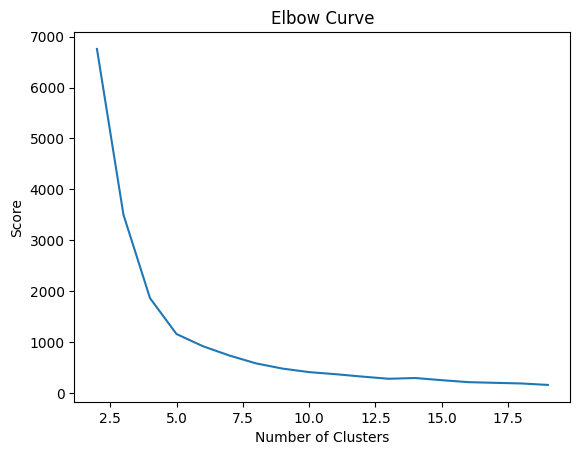

In [32]:
import pandas as pd
import pylab as pl

df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]

new_col = range(2,20)
df_cost.insert(0, 'cluster', new_col)

pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

### Build KMeans Clustering Model

Lalu kita bisa melihat titik curam disekitaran 4 dan 5
sebagai contoh saya mengambil 4

In [33]:
model = KMeans(featuresCol='standardized',k=4)
model = model.fit(data_scaled)

### Membuat Prediksi Cluster untuk setiap Customer

In [34]:
pred = model.transform(data_scaled)
pred.show(5,0)

+--------+-----------+-----------------+----------+-----------------------------------+--------------------------------------------------------------+----------+
|recency |Freq Jumlah|monetary_value   |CustomerID|features                           |standardized                                                  |prediction|
+--------+-----------+-----------------+----------+-----------------------------------+--------------------------------------------------------------+----------+
|5580    |14         |226.14           |16250     |[5580.0,14.0,226.14]               |[1.8278066676832049E-7,0.4589020319425581,0.07645669520731259]|0         |
|2704800 |121        |375.65           |15574     |[2704800.0,121.0,375.65]           |[8.859948879479449E-5,3.9662247046463945,0.12700520719300865] |3         |
|21100860|24         |111.75           |15271     |[2.110086E7,24.0,111.75]           |[6.911880394596744E-4,0.7866891976158138,0.03778206283460327] |0         |
|21112020|37         |620.34

In [35]:
pred[['prediction']].distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         3|
|         2|
|         0|
+----------+



### VISUALISASI HASIL CLUSTERING 

In [40]:
# Coming Soon Insyaallah